# Train a dataset

### 1 making dataset (create a intents.json)

### 2 import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

## 3 || Exploratory Data Analysis with Visualization (EDA + VIS)

### 3.1 || Load the data

In [4]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = 'dataset.json'

intents = load_json_file(filename)

###  3.2 || Extract Info from the Json data file and Store it in dataframe

In [5]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = create_df()
df

,Pattern,Tag


In [6]:
def extract_json_info(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,"What is a compiler, and how does it differ fro...",Compiler
1,Compiler vs Interpreter,Compiler
2,Explain the distinction between a compiler and...,Compiler
3,What are the primary differences between compi...,Compiler
4,Describe the role of a compiler and an interpr...,Compiler


In [7]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,"What is a compiler, and how does it differ fro...",Compiler
1,Compiler vs Interpreter,Compiler
2,Explain the distinction between a compiler and...,Compiler
3,What are the primary differences between compi...,Compiler
4,Describe the role of a compiler and an interpr...,Compiler



### 3.3 || Check the shape of the dataset

In [8]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "SmartGrader")

SmartGrader dataset has 404 rows and 2 columns


### 3.4 || Display information about the dataset

In [9]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())
    
print_dfInfo(df, "SmartGrader")

The info of SmartGrader dataset

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 0 to 403
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  404 non-null    object
 1   Tag      404 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
None


### 3.5 || Display Number of Classes

In [10]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
num_classes(df, 'Tag', "SmartGrader")

The SmartGrader dataset has 40 classes


### 3.6 || Check the null values in the dataset

In [11]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


### 3.7 || Visualize the Null Values

##### this dataset hasn't null values because this dataset create on my hand.

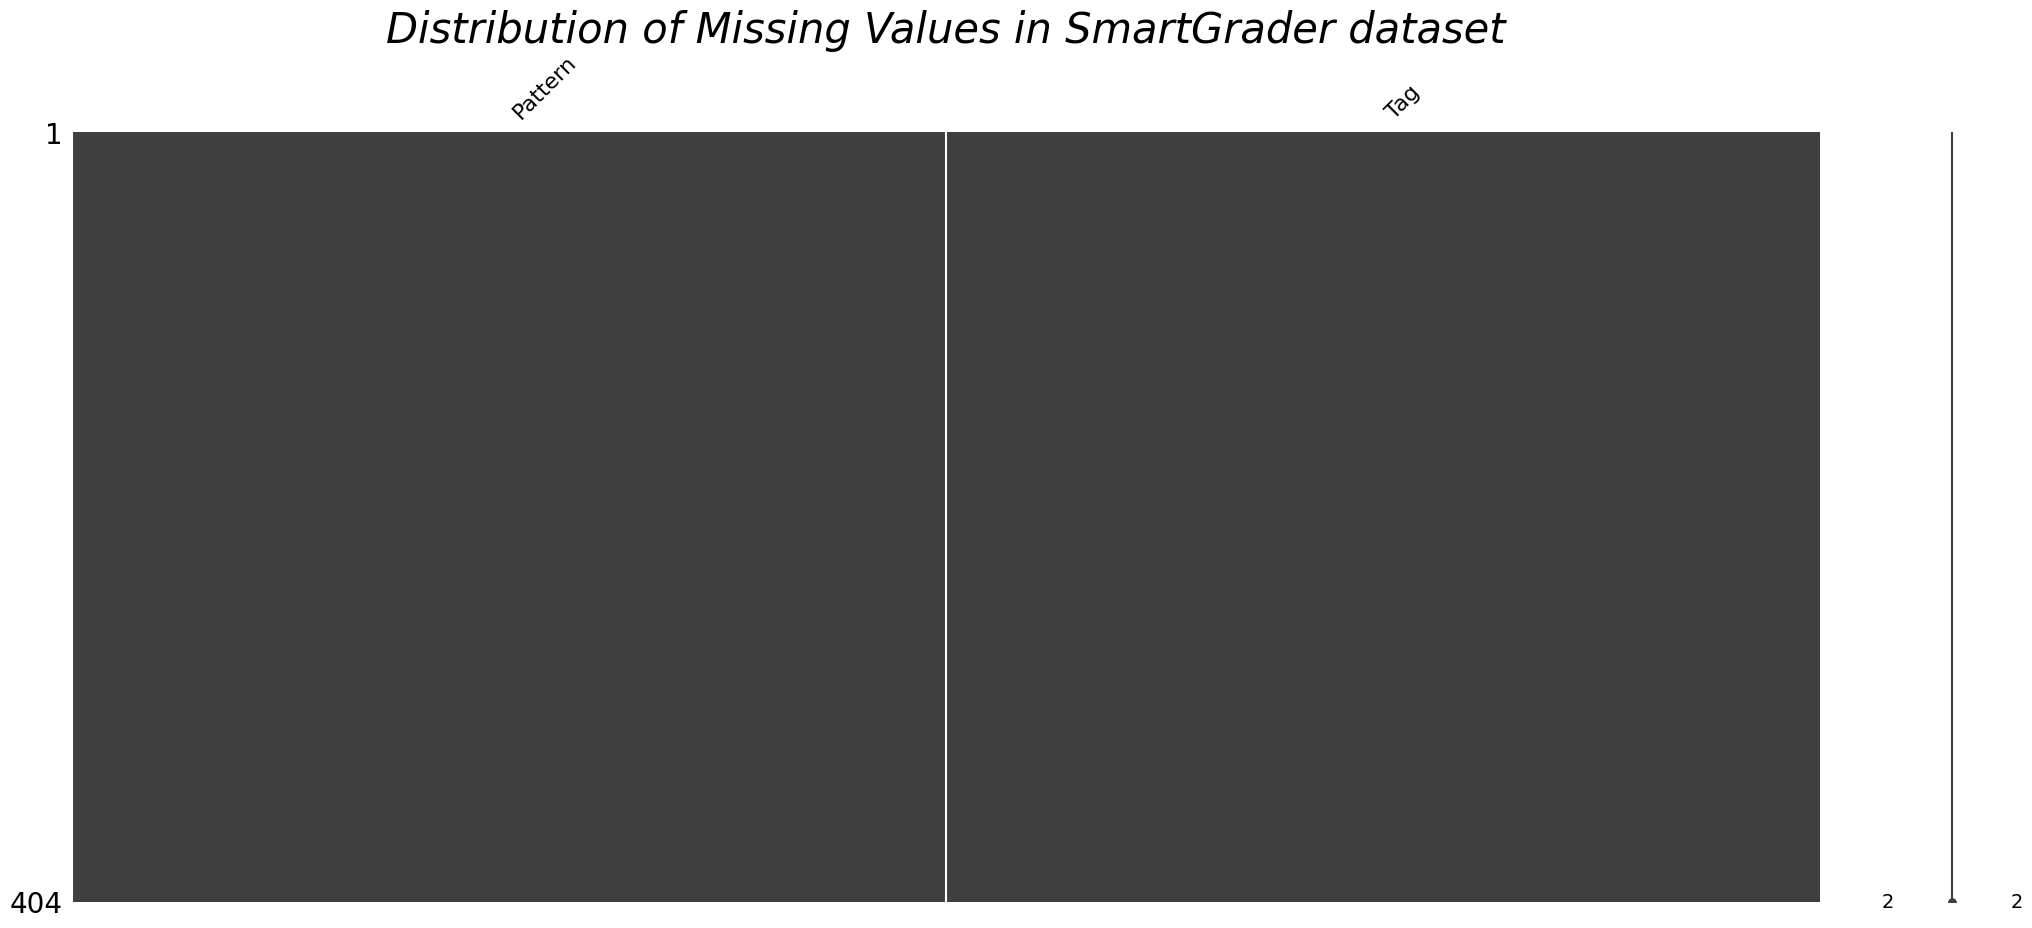

In [12]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()
    
plot_miss_vals(df, "SmartGrader")

### 3.8 || Visualize the distrbution of our Classes

In [13]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

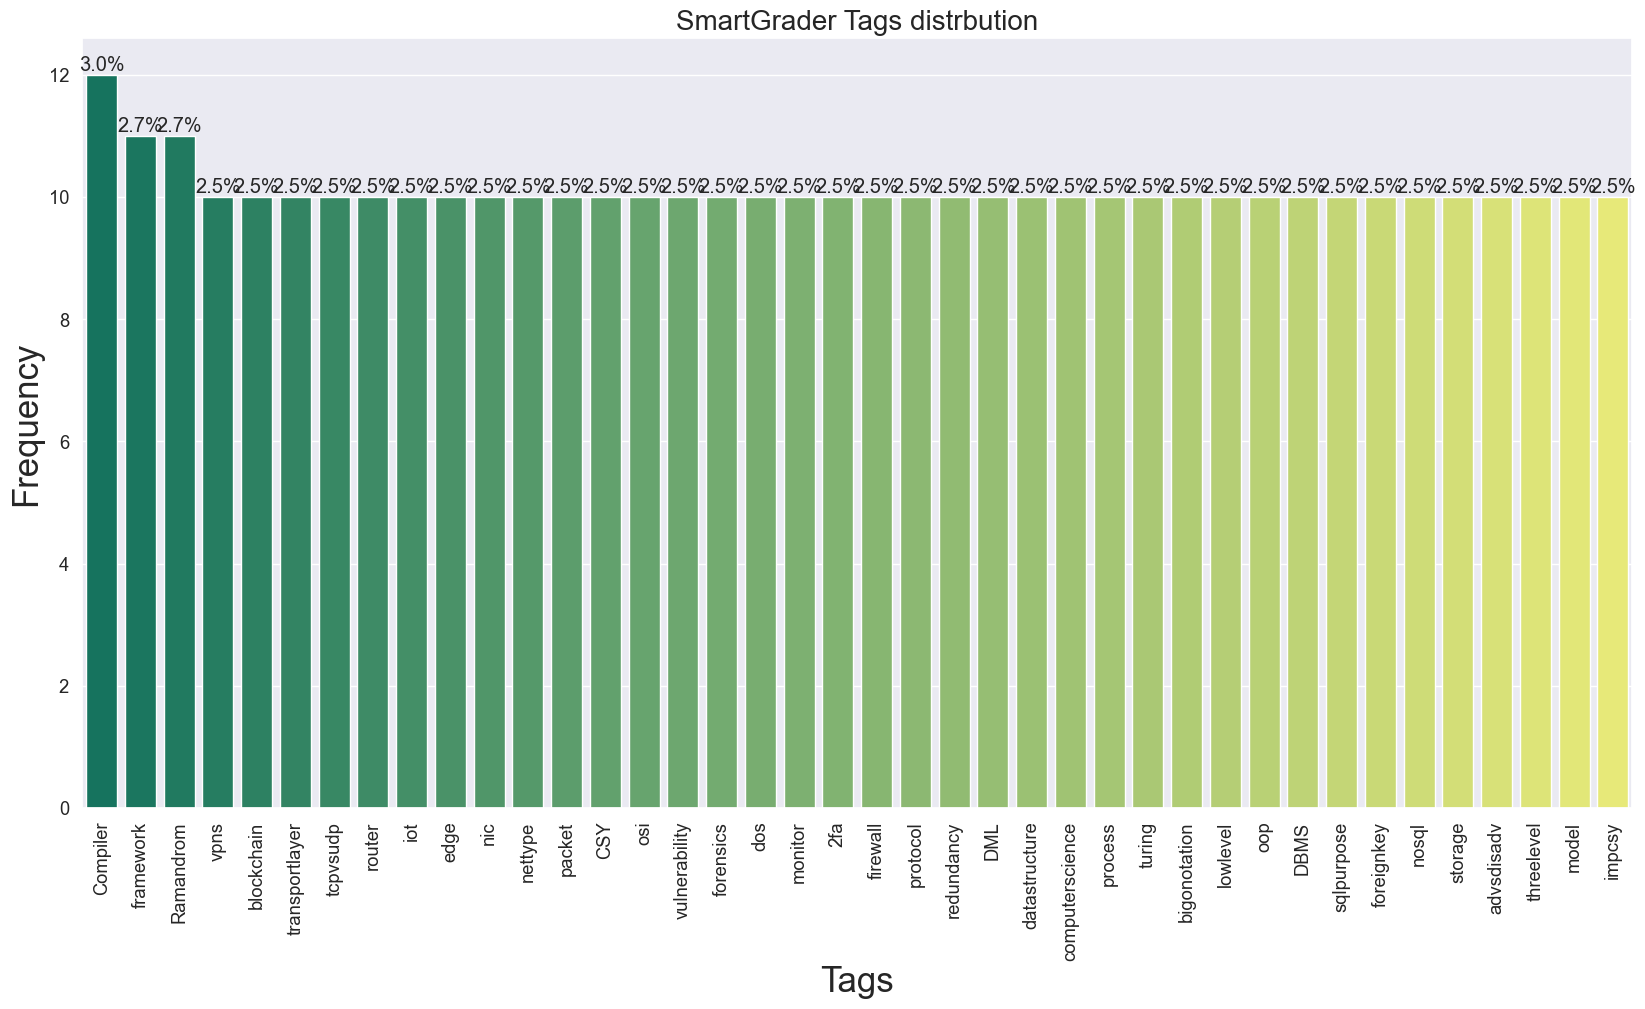

In [14]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "SmartGrader Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [15]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [16]:
df.head()

,Pattern,Tag
0,what is a compil and how doe it differ from an...,Compiler
1,compil vs interpret,Compiler
2,explain the distinct between a compil and an i...,Compiler
3,what are the primari differ between compil and...,Compiler
4,describ the role of a compil and an interpret ...,Compiler


In [17]:
print(df['Pattern'].isnull().sum())

0


### 3.9 || Display Word Cloud

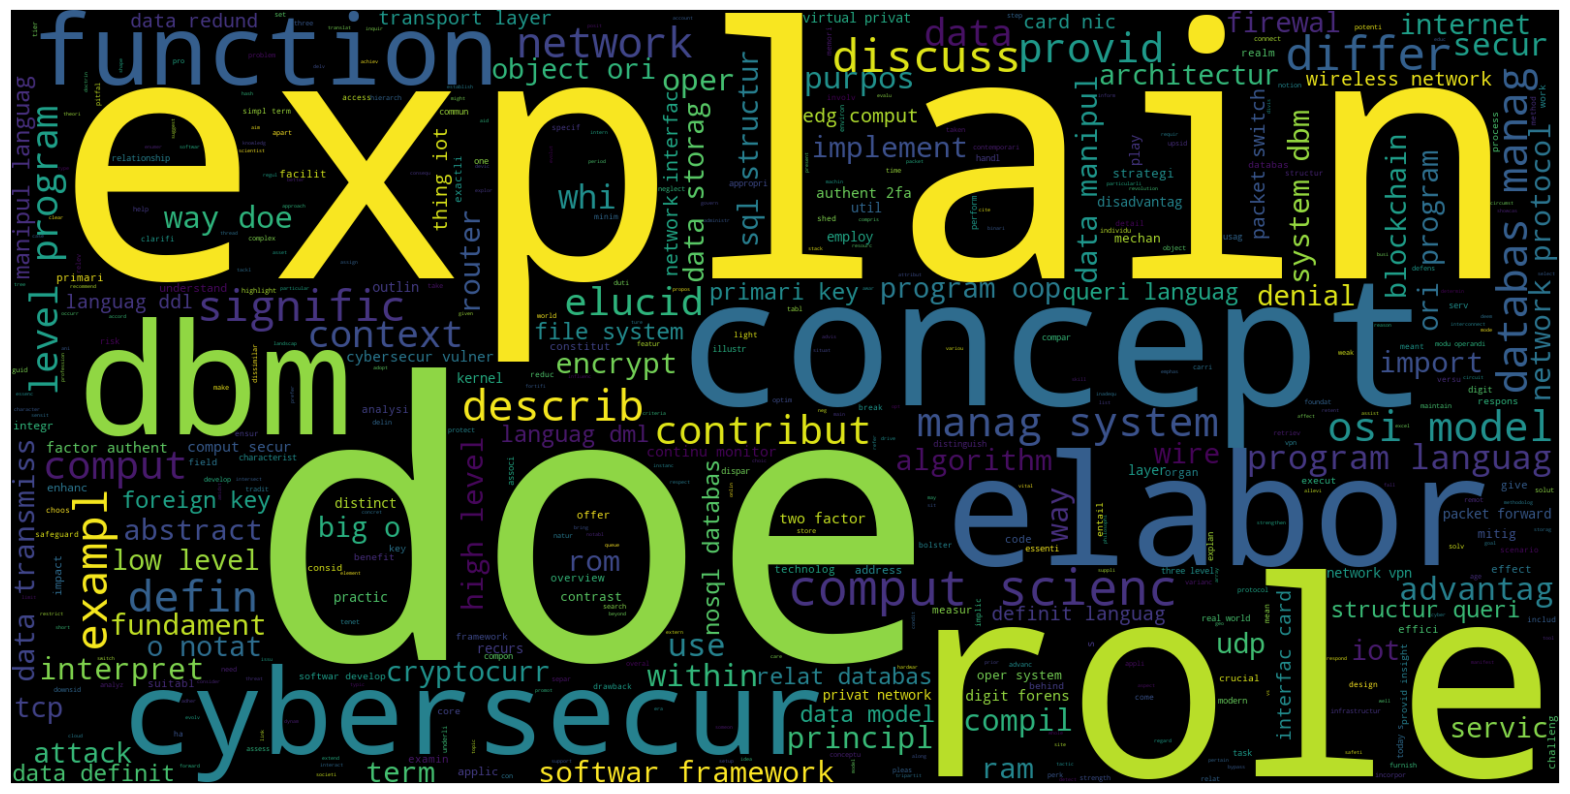

In [18]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

### 3.10 || Distrbution of Number of letters in each text

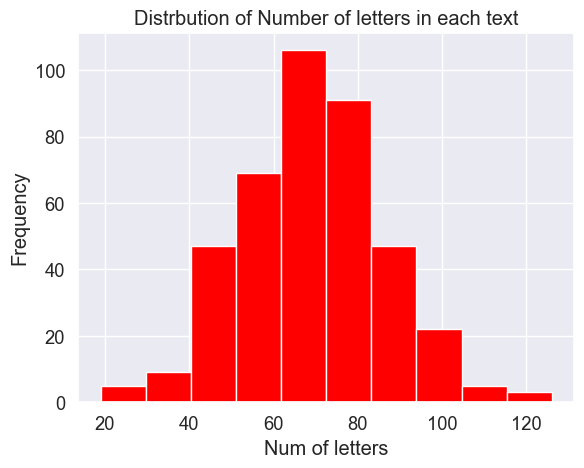

In [20]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

### 3.11 || Distrbution of Number of words in each text

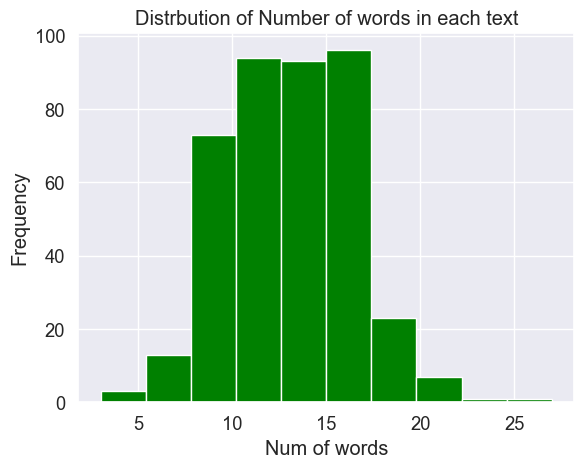

In [21]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

### 3.12 || Visualize Average word length in each text

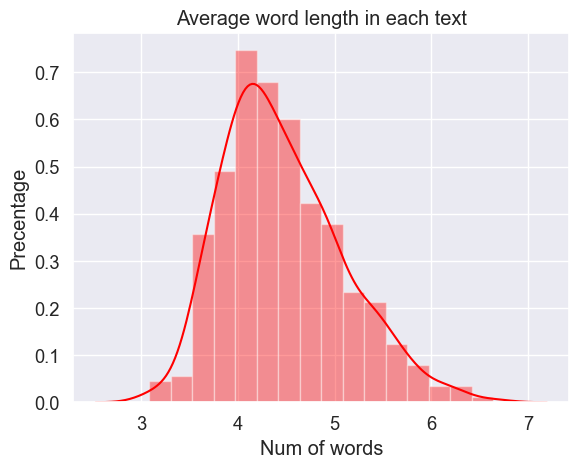

In [22]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

### 3.13 || Visualize top words

In [23]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['what', 'is', 'a', 'compil', 'and']

In [24]:
print(f"dataset contains {len(corpus)} words")

dataset contains 5262 words


In [25]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'the': 338,
 'of': 253,
 'and': 247,
 'in': 195,
 'a': 192,
 'what': 185,
 '(': 100,
 ')': 100,
 'it': 98,
 'how': 82}

In [26]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

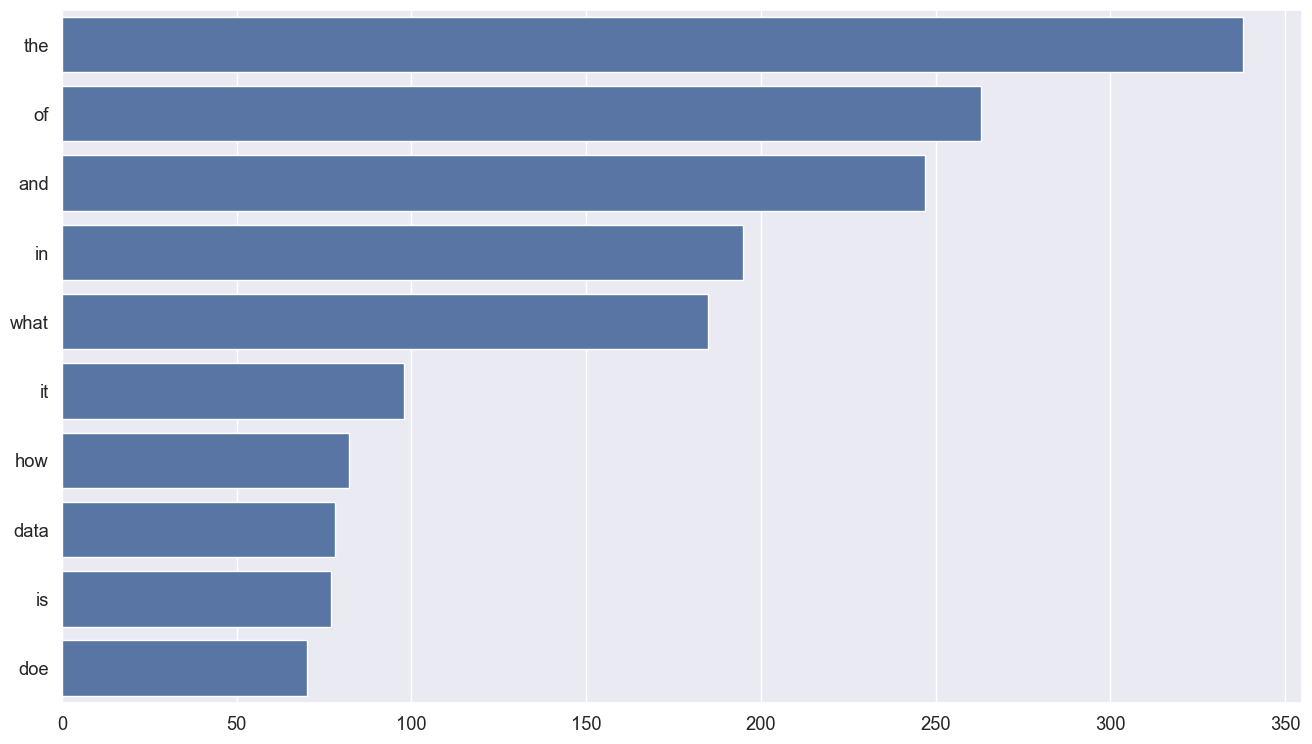

In [27]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

### 4 || Data Preprocessing

In [28]:
df2.head()

,Pattern,Tag
0,"What is a compiler, and how does it differ fro...",Compiler
1,Compiler vs Interpreter,Compiler
2,Explain the distinction between a compiler and...,Compiler
3,What are the primary differences between compi...,Compiler
4,Describe the role of a compiler and an interpr...,Compiler


In [29]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['Compiler',
 'Ramandrom',
 'datastructure',
 'computerscience',
 'process',
 'turing',
 'framework',
 'bigonotation',
 'lowlevel',
 'oop',
 'DBMS',
 'sqlpurpose',
 'foreignkey',
 'nosql',
 'storage',
 'advsdisadv',
 'threelevel',
 'model',
 'DML',
 'redundancy',
 'protocol',
 'osi',
 'transportlayer',
 'tcpvsudp',
 'router',
 'iot',
 'edge',
 'nic',
 'nettype',
 'packet',
 'CSY',
 'firewall',
 'vulnerability',
 'forensics',
 'dos',
 '2fa',
 'blockchain',
 'vpns',
 'monitor',
 'impcsy']

In [30]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [31]:
id2label

{0: 'Compiler',
 1: 'Ramandrom',
 2: 'datastructure',
 3: 'computerscience',
 4: 'process',
 5: 'turing',
 6: 'framework',
 7: 'bigonotation',
 8: 'lowlevel',
 9: 'oop',
 10: 'DBMS',
 11: 'sqlpurpose',
 12: 'foreignkey',
 13: 'nosql',
 14: 'storage',
 15: 'advsdisadv',
 16: 'threelevel',
 17: 'model',
 18: 'DML',
 19: 'redundancy',
 20: 'protocol',
 21: 'osi',
 22: 'transportlayer',
 23: 'tcpvsudp',
 24: 'router',
 25: 'iot',
 26: 'edge',
 27: 'nic',
 28: 'nettype',
 29: 'packet',
 30: 'CSY',
 31: 'firewall',
 32: 'vulnerability',
 33: 'forensics',
 34: 'dos',
 35: '2fa',
 36: 'blockchain',
 37: 'vpns',
 38: 'monitor',
 39: 'impcsy'}

In [32]:
label2id

{'Compiler': 0,
 'Ramandrom': 1,
 'datastructure': 2,
 'computerscience': 3,
 'process': 4,
 'turing': 5,
 'framework': 6,
 'bigonotation': 7,
 'lowlevel': 8,
 'oop': 9,
 'DBMS': 10,
 'sqlpurpose': 11,
 'foreignkey': 12,
 'nosql': 13,
 'storage': 14,
 'advsdisadv': 15,
 'threelevel': 16,
 'model': 17,
 'DML': 18,
 'redundancy': 19,
 'protocol': 20,
 'osi': 21,
 'transportlayer': 22,
 'tcpvsudp': 23,
 'router': 24,
 'iot': 25,
 'edge': 26,
 'nic': 27,
 'nettype': 28,
 'packet': 29,
 'CSY': 30,
 'firewall': 31,
 'vulnerability': 32,
 'forensics': 33,
 'dos': 34,
 '2fa': 35,
 'blockchain': 36,
 'vpns': 37,
 'monitor': 38,
 'impcsy': 39}

In [33]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,"What is a compiler, and how does it differ fro...",Compiler,0
1,Compiler vs Interpreter,Compiler,0
2,Explain the distinction between a compiler and...,Compiler,0
3,What are the primary differences between compi...,Compiler,0
4,Describe the role of a compiler and an interpr...,Compiler,0


### 5 || Split the data into train and test

In [34]:
X = list(df2['Pattern'])
X[:5]

['What is a compiler, and how does it differ from an interpreter?',
 'Compiler vs Interpreter',
 'Explain the distinction between a compiler and an interpreter in programming.',
 'What are the primary differences between compilers and interpreters?',
 'Describe the role of a compiler and an interpreter in executing code.']

In [35]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

### 6 || Load BERT Pretrained model and Tokenizer

In [37]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 7 || Transform the data into numerical format

In [38]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [39]:
full_data = tokenizer(X, truncation=True, padding=True)

### 8 || Build Data Loader

In [40]:
class DataLoader(Dataset):
    
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
               
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [41]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [42]:
fullDataLoader = DataLoader(full_data, y_test)

### 9 || Define Evaluation Metrcies

In [43]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

### 10 || Define Training Arguments

In [48]:
training_args = TrainingArguments(
    output_dir='./output', 
    do_train=True,
    do_eval=True,
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=100,                
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)

### 11 || Train the model

In [49]:
trainer = Trainer(
    model=model,
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=test_dataloader,            
    compute_metrics= compute_metrics
)

In [50]:
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.3979, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3315195143222809, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5202, 'eval_samples_per_second': 194.159, 'eval_steps_per_second': 13.457, 'epoch': 5.0}
{'loss': 0.2205, 'learning_rate': 5e-05, 'epoch': 10.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.12947624921798706, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5204, 'eval_samples_per_second': 194.092, 'eval_steps_per_second': 13.452, 'epoch': 10.0}
{'loss': 0.0797, 'learning_rate': 4.722222222222222e-05, 'epoch': 15.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.04877998307347298, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5488, 'eval_samples_per_second': 184.025, 'eval_steps_per_second': 12.754, 'epoch': 15.0}
{'loss': 0.04, 'learning_rate': 4.4444444444444447e-05, 'epoch': 20.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.030036723241209984, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5179, 'eval_samples_per_second': 195.033, 'eval_steps_per_second': 13.517, 'epoch': 20.0}
{'loss': 0.027, 'learning_rate': 4.166666666666667e-05, 'epoch': 25.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.021473471075296402, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5342, 'eval_samples_per_second': 189.082, 'eval_steps_per_second': 13.105, 'epoch': 25.0}
{'loss': 0.0198, 'learning_rate': 3.888888888888889e-05, 'epoch': 30.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.01669463701546192, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5296, 'eval_samples_per_second': 190.716, 'eval_steps_per_second': 13.218, 'epoch': 30.0}
{'loss': 0.0159, 'learning_rate': 3.611111111111111e-05, 'epoch': 35.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.013846887275576591, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5296, 'eval_samples_per_second': 190.706, 'eval_steps_per_second': 13.217, 'epoch': 35.0}
{'loss': 0.013, 'learning_rate': 3.3333333333333335e-05, 'epoch': 40.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.011442211456596851, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5389, 'eval_samples_per_second': 187.407, 'eval_steps_per_second': 12.989, 'epoch': 40.0}
{'loss': 0.0112, 'learning_rate': 3.055555555555556e-05, 'epoch': 45.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.010058765299618244, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5375, 'eval_samples_per_second': 187.896, 'eval_steps_per_second': 13.023, 'epoch': 45.0}
{'loss': 0.0097, 'learning_rate': 2.777777777777778e-05, 'epoch': 50.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.008851056918501854, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5253, 'eval_samples_per_second': 192.283, 'eval_steps_per_second': 13.327, 'epoch': 50.0}
{'loss': 0.0086, 'learning_rate': 2.5e-05, 'epoch': 55.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.007933699525892735, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.519, 'eval_samples_per_second': 194.622, 'eval_steps_per_second': 13.489, 'epoch': 55.0}
{'loss': 0.0078, 'learning_rate': 2.2222222222222223e-05, 'epoch': 60.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.007203360553830862, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5126, 'eval_samples_per_second': 197.022, 'eval_steps_per_second': 13.655, 'epoch': 60.0}
{'loss': 0.0072, 'learning_rate': 1.9444444444444445e-05, 'epoch': 65.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.006777085829526186, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5187, 'eval_samples_per_second': 194.729, 'eval_steps_per_second': 13.496, 'epoch': 65.0}
{'loss': 0.0067, 'learning_rate': 1.6666666666666667e-05, 'epoch': 70.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.006290630903095007, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5202, 'eval_samples_per_second': 194.138, 'eval_steps_per_second': 13.455, 'epoch': 70.0}
{'loss': 0.0063, 'learning_rate': 1.388888888888889e-05, 'epoch': 75.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.005995753221213818, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5287, 'eval_samples_per_second': 191.044, 'eval_steps_per_second': 13.241, 'epoch': 75.0}
{'loss': 0.006, 'learning_rate': 1.1111111111111112e-05, 'epoch': 80.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.005720804911106825, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.6983, 'eval_samples_per_second': 144.633, 'eval_steps_per_second': 10.024, 'epoch': 80.0}
{'loss': 0.0057, 'learning_rate': 8.333333333333334e-06, 'epoch': 85.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.005526302848011255, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5354, 'eval_samples_per_second': 188.645, 'eval_steps_per_second': 13.074, 'epoch': 85.0}
{'loss': 0.0056, 'learning_rate': 5.555555555555556e-06, 'epoch': 90.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.00539507856592536, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5278, 'eval_samples_per_second': 191.359, 'eval_steps_per_second': 13.263, 'epoch': 90.0}
{'loss': 0.0055, 'learning_rate': 2.777777777777778e-06, 'epoch': 95.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.005313864443451166, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.5134, 'eval_samples_per_second': 196.745, 'eval_steps_per_second': 13.636, 'epoch': 95.0}
{'loss': 0.0054, 'learning_rate': 0.0, 'epoch': 100.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.005296248011291027, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.533, 'eval_samples_per_second': 189.491, 'eval_steps_per_second': 13.133, 'epoch': 100.0}
{'train_runtime': 666.3351, 'train_samples_per_second': 45.473, 'train_steps_per_second': 1.501, 'train_loss': 0.04496371179819107, 'epoch': 100.0}


TrainOutput(global_step=1000, training_loss=0.04496371179819107, metrics={'train_runtime': 666.3351, 'train_samples_per_second': 45.473, 'train_steps_per_second': 1.501, 'train_loss': 0.04496371179819107, 'epoch': 100.0})

### 12 || Evaluate the model

In [54]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.003706,1.0,1.0,1.0,1.0
test,0.005296,1.0,1.0,1.0,1.0


In [55]:
def predict(text):
    
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [57]:
#text = "What is a compiler"
#predict(text)

### 13 || Save the model

In [53]:
model_path = "smg_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('smg_model/tokenizer_config.json',
 'smg_model/special_tokens_map.json',
 'smg_model/vocab.txt',
 'smg_model/added_tokens.json')

In [ ]:
!pip install xformers

### 14 || Load the model

In [58]:
model_path = "smg_model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
smg= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [59]:
smg("What is a compiler")

[{'label': 'Compiler', 'score': 0.9967072606086731}]

### 15 || Ask question with the SmartGrader

In [60]:
def quiz(smgs):
    
    text = smgs.strip().lower()
    
    score = smg(text)[0]['score']
        
        
    label = label2id[smg(text)[0]['label']]
    response = random.choice(intents['intents'][label]['responses'])
        
    print(f"smartgrader: {response}\n\n")



In [61]:
data = "What is a compiler"
quiz(data)

smartgrader: A compiler translates the entire source code into machine code or an intermediate form before execution, while an interpreter processes and executes the code line by line in real-time without creating a separate compiled file.


